In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

First we remove the call columns and gene descriptions as these won't be used in the analysis

In [153]:
train=pd.read_csv('data_set_ALL_AML_train.csv').T
train = train.drop([c for c in train.index if 'call' in c],axis=0)
independent=pd.read_csv('data_set_ALL_AML_independent.csv').T
independent = independent.drop([c for c in independent.index if 'call' in c],axis=0)
labels=pd.read_csv('actual.csv')
data = pd.concat([train[2:],independent[2:]]).astype(int)
data.index = data.index.map(int)
data = data.sort_index()
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
68,-154,-136,49,180,-257,-273,141,-123,52,878,...,214,540,13,1075,-45,524,249,40,-68,-1
69,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
70,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40
71,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,214,760,-38,201,-55,348,208,0,74,-12
72,-131,-126,-50,211,-206,-287,-34,-114,62,341,...,206,697,3,1046,27,874,393,34,237,-2


Next we reduce the number of genes to reduce noise and reduce memory use. From the paper correlation of 0.3 is at least 1% significant, so that's probably a good place to start

In [154]:
target = np.where(labels['cancer']=='ALL',1,-1)
results=[]
for i in range(0,7129):
    if abs(np.corrcoef(train[2:][i].to_numpy(dtype=int),target[:38])[1,0])>0.3:
        results+=[i]
train = train[2:].filter(results)
data=data.filter(results)
independent = data[38:]

# Clustering

First lets try some common clustering algorithms

In [161]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
kmeans.fit(train)

spectral = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=1000)
spectral.fit(train)

ward = cluster.AgglomerativeClustering(linkage='ward',n_clusters=2)
ward.fit(train)

c:\users\victor\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

Text(0.5, 1.0, 'Ward')

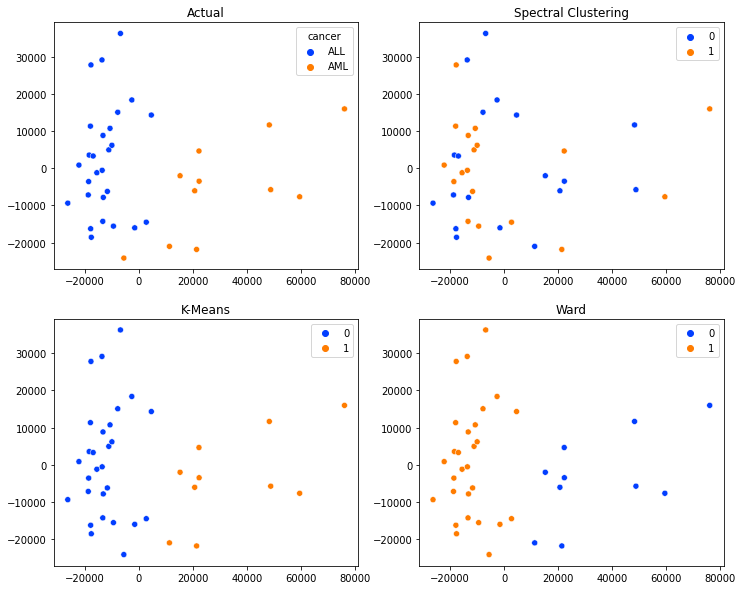

In [162]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(train)

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
# actual
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels['cancer'][:38], legend='full', palette=palette,ax=ax1[0])
ax1[0].set_title('Actual')
# k-means
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=kmeans.labels_, legend='full', palette=palette,ax=ax2[0])
ax2[0].set_title('K-Means')
# mean shift
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=spectral.labels_, legend='full', palette=palette,ax=ax1[1])
ax1[1].set_title('Spectral Clustering')
# ward
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=ward.labels_, legend='full', palette=palette,ax=ax2[1])
ax2[1].set_title('Ward')

We can see K means and Ward are able to closely match the actual clusters. Now we can try applying the K means predictions to the test set.

Accuracy:  0.8529411764705882


Text(0.5, 1.0, 'K-Means')

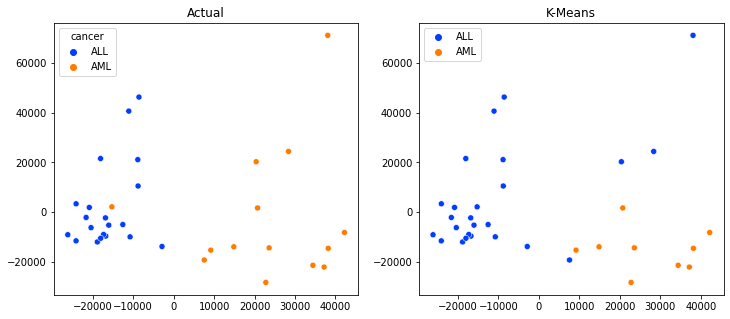

In [163]:
def accuracy(predictions,ALL=1):
    c=0
    for p in range(len(predictions)):
        if labels['cancer'][p+38] == ('ALL' if ALL == predictions[p] else 'AML'):
            c+=1
    print('Accuracy: ',c/34)
accuracy(kmeans.predict(independent),0)

pca_result = pca.fit_transform(independent)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# actual
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels['cancer'][38:], legend='full', palette=palette,ax=ax1)
ax1.set_title('Actual')
# k-means
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=['ALL' if k == 0 else 'AML' for k in kmeans.predict(independent)], legend='full', palette=palette,ax=ax2)
ax2.set_title('K-Means')

# Self Organizing Map

The paper uses a self organizing map for its analysis. To use the minisom package we convert our variables to an array, and normalize each of them.

In [174]:
from minisom import MiniSom
n_neurons = 9
m_neurons = 9
som = MiniSom(n_neurons, m_neurons, train.shape[1], sigma=2, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)
target = np.where(labels['cancer']=='ALL',1,0)[:38]
t = train.to_numpy(dtype=int)
t = (t - np.mean(t, axis=0)) / np.std(t, axis=0)
som.pca_weights_init(t)
som.train(t, 100000, verbose=True)

c:\users\victor\appdata\local\programs\python\python37-32\lib\site-packages\minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 14.010043870424411


The 81 neurons are plotted below, with an indicator of their category as assumed from the patient mapped there.

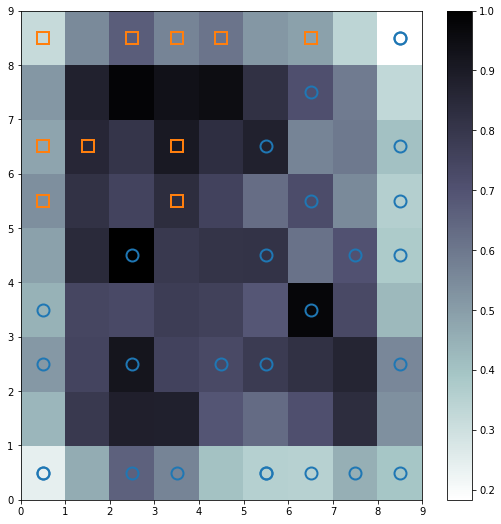

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(t):
    w = som.winner(xx)  
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

This secound plot shows the density of the patients. Data is very sparse, so we could probably make do with less neurons.

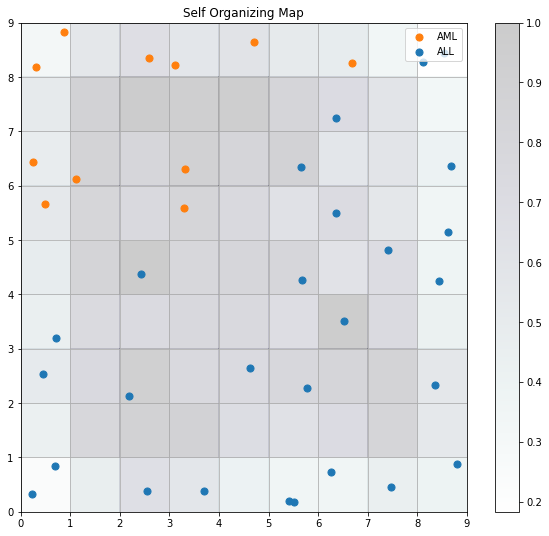

In [189]:
w_x, w_y = zip(*[som.winner(x) for x in t])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=(["AML","ALL"])[c])
plt.legend(loc='upper right')
plt.title("Self Organizing Map")
plt.grid()
plt.show()

We can construct a rudimentry classifier by mapping points to the plot, and given that a mapped to cluster is empty, assume the point is of the class of a neighboring cluster.

In [185]:
from sklearn.model_selection import train_test_split
a=np.array([0,1])
k=independent.to_numpy(dtype=float)
df=pd.DataFrame(columns=['real','prediction'])
df['real']=labels['cancer'][38:]

# Modified from https://github.com/JustGlowing/minisom/blob/master/examples/Classification.ipynb
square = [0,1,0,-1,0]
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(t, labels['cancer'][:38])
    result = []
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            s=[]
            for i in range(0,4):
                p = tuple(sum(x) for x in zip(win_position, (square[i],square[i+1])))
                if p in winmap:
                    s.append(winmap[p])
            if(not np.sum(s) == 0):
                result.append(np.sum(s).most_common()[0][0])
            else:
                result.append(default_class)
    return result
df['prediction'] = classify(som,independent.to_numpy(dtype=int))

Accuracy: 0.9117647058823529


Text(0.5, 1.0, 'SOM')

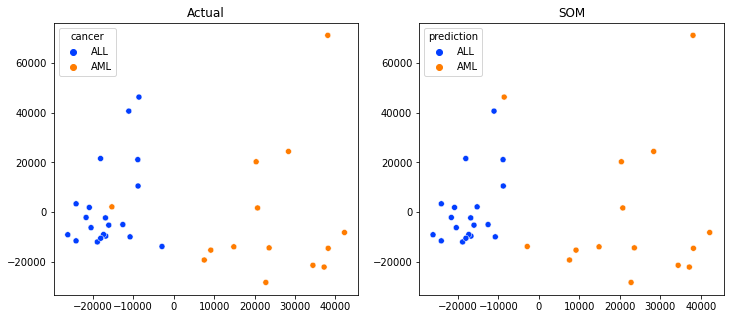

In [186]:
from sklearn.decomposition import PCA
c=0
for v in df.values:
    if v[1] == v[0]: c+=1
print('Accuracy:',c/34)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(independent)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# actual
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels['cancer'][38:], legend='full', palette=palette,ax=ax1)
ax1.set_title('Actual')
# som
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['prediction'], legend='full', palette=palette,ax=ax2)
ax2.set_title('SOM')

In [190]:
independent

,3,7,16,19,23,26,28,34,35,41,...,7060,7061,7062,7086,7093,7104,7117,7118,7124,7127
39,328,-292,-7,57,-181,-2,41,-289,-195,6339,...,663,661,977,429,381,-352,-451,2112,1074,168
40,295,-452,-163,21,81,-234,24,-417,-589,10756,...,557,368,1172,544,288,-304,-2406,1323,67,-33
41,142,-97,-111,67,-103,-137,-10,-158,-56,10171,...,302,314,262,377,223,-187,-577,1033,245,100
42,276,-141,-182,41,-15,-120,-37,-153,-124,15439,...,337,313,576,519,363,-131,-3710,826,893,1971
43,252,-197,-201,9,-93,-228,38,-372,-312,12489,...,283,346,564,334,139,-302,-2651,937,1235,1545
44,174,-152,117,-807,-1700,-256,-59,-1725,-1694,20411,...,330,554,744,364,213,-204,-266,1691,354,45
45,142,-133,25,-774,-664,-178,-44,-1573,-1365,16760,...,334,392,748,412,174,-200,-676,479,304,112
46,177,-62,7,14,-137,33,-69,-137,134,19690,...,209,252,1015,228,235,-216,-599,438,625,63
47,182,-172,-31,84,-271,-2,-23,-191,52,7760,...,418,449,788,222,205,-69,-1460,613,722,510
48,266,-93,-100,-20,-19,-82,-44,-413,-437,14640,...,404,319,1526,414,322,-124,-677,1475,612,333
